# Brand Intelligence Solution -  (ADS Track Transfer Case Study)

Importing the Necessary Libraries and Loading the Data

In [1]:
!pip install sklearn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install re
!pip install nltk
!pip install stanfordnlp
!pip install tqdm
!pip install gensim
!pip install warnings
!pip install wordcloud
!pip install textblob
!pip install heapq
!pip install collections
!pip install plotly
!pip install datapane
!pip install sentence_transformers
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 158 kB 3.2 MB/s 
Looking in indexes

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.stem.porter import *
import string
import stanfordnlp
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from gensim import corpora, models
from wordcloud import WordCloud
import gensim
from textblob import TextBlob
from heapq import nlargest
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
import datapane as dp
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Preprocessing the Data**

In [4]:
train = pd.read_csv('./Raw_Data.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9185 entries, 0 to 9184
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9185 non-null   int64  
 1   content  9185 non-null   object 
 2   date     9185 non-null   object 
 3   product  9183 non-null   object 
 4   brand    8988 non-null   object 
 5   rating   9185 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 430.7+ KB


In [5]:
train.isnull().sum(axis = 0)

id           0
content      0
date         0
product      2
brand      197
rating       0
dtype: int64

So the data have 2 null products and 197 null brands. Now we will fill the Null products with "Unknown" as we have no idea about these products and prepare a strategy to deal with null brands.

To define brands the approach is to extract product keywords and use them to define the Unknown brands

In [6]:
"""" Filling the null product with Unknown Keyword """
train['product'] = train['product'].fillna("Unknown")

"""" Approach is to extract product keywords 
    and use them to define the Unknown brands """ 

def convertprodname(name):
    position_ = name.find('-')
    if(position_ == -1):
        position_ = name.find(' ')
    return name[:position_]
train['product_key'] = train['product'].apply(lambda x: convertprodname(x))

product_key_brand_dic = train[train['brand'].notnull()].drop_duplicates()[['product_key','brand']].set_index('product_key').T.to_dict('list')

for i,row in train.iterrows():
    if(row.brand != row.brand):
        try:
            brand_null = product_key_brand_dic[row.product_key]
        except:
            brand_null = row.product_key
        brand_null = str(brand_null)
        brand_null = brand_null.replace("[",'').replace("]",'').replace('"','').replace("'",'')
        train.at[i,'brand'] = brand_null

Now after dealing with null values we'll proceed towards Pre Processing the Text Data (reviews)

We will be deleting the absurd characters, remove spaces, converting the short form of verbs to there full forms,
removing brackets and converting numerical values to text and lastly removing stop words

In [7]:
"""" We will delete the absurd characters, remove spaces, converting the short form of verbs
     to there full forms, removing brackets and converting numerical values to text and lastly removing stop words """ 

train['content'] = train['content'].map(lambda x: re.sub('\\n',' ',str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'\W',' ',str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'https\s+|www.\s+',r'', str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'http\s+|www.\s+',r'', str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'\s+',' ',str(x)))
train['content'] = train['content'].str.lower()
train['content'] = train['content'].map(lambda x: re.sub(r"\’", "\'", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"dont", "do not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'re", " are", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'s", " is", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\’d", " would", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\d", " would", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'t", " not", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'m", " am", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\n", "", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\r", "", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\'", "", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r"\"", "", str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
train['content'] = train['content'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))

stop_words = stopwords.words('english')
train['content'] = train['content'].apply(lambda x: ' '.join([word for word in x.split() if (word not in (stop_words) and word not in string.punctuation)]))

### Now after preprocessing the textual data let's just jump in to our problem statement

**Objective 1:**

*Identify key Attributes of each product at review level*

We'll be using the NER methods on our textual data to extract keywords and apply algorithm to extract attributes.

* First step would be to tokenize our preprocessed textual data
* Next step would be to give position tags to data using nltk library
* Next we'll identify the nouns from the position tags and store it
* Generate the corpus based on TFIDF tokens
* Finally we would use topic modelling using LDA to identify the topics associated to each review
* Visualizing the distribution of keywords using Word2Vec model to generate correlated words (in Presentation Layer)

In [8]:
featureList = []
token_list = []
all_sentences = []
dic = {}
for sentence in tqdm(train['content']):
    tokenize_word = nltk.word_tokenize(sentence)
    taggedList = nltk.pos_tag(tokenize_word)
    newwordList = []
    flag = 0
    newwordList = taggedList
    finaltxt = ' '.join(word[0] for word in taggedList)
    new_txt_list = nltk.word_tokenize(finaltxt)
    wordsList = [w for w in new_txt_list if not w in stop_words]
    taggedList = nltk.pos_tag(wordsList)
    categories = []
    review_nouns = ''
    for i in taggedList:
        if(i[1]=='NN'):
            featureList.append((i[0]))
            categories.append(i[0])
            dic[i[0]] = 0
    token_list.append(categories)
    review_nouns = ' '.join(word for word in categories)
    all_sentences.append(review_nouns)

100%|██████████| 9185/9185 [01:00<00:00, 151.34it/s]


In [9]:
"""Generate the corpus of all the nouns in each review and Dictionary for topic Modelling"""

dataw2v = []
for sentence in all_sentences:
    temp = []
    for word in word_tokenize(sentence):
        temp.append(word)
    dataw2v.append(temp)
    
dictionary = gensim.corpora.Dictionary(token_list)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

""" Generate the corpus of tokenized words """

bow_corpus = [dictionary.doc2bow(doc) for doc in token_list]

In [10]:
""" Now we have the tokens for each of the words and the frequency of that word in the sentence"""

bow_doc_ex = bow_corpus[1]
for i in range(len(bow_doc_ex)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_ex[i][0], 
                                               dictionary[bow_doc_ex[i][0]], bow_doc_ex[i][1]))

Word 6 ("choice") appears 1 time.
Word 7 ("price") appears 1 time.


In [11]:
"""stemmer = SnowballStemmer(language = 'english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
final = []
for doc in token_list:
    result = [lemmatize_stemming(word) for word in doc if len(word) > 3]
    final.append(result)
final
token_list = final"""

"stemmer = SnowballStemmer(language = 'english')\ndef lemmatize_stemming(text):\n    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))\nfinal = []\nfor doc in token_list:\n    result = [lemmatize_stemming(word) for word in doc if len(word) > 3]\n    final.append(result)\nfinal\ntoken_list = final"

In [12]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [13]:
""" Training the LDA model based on TFIDF Corpus and Printing the words associated with each topic"""

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(10,5):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.041*"beer" + 0.022*"taste" + 0.013*"price" + 0.013*"fruity" + 0.012*"love"
Topic: 1 Word: 0.018*"beer" + 0.015*"taste" + 0.015*"orange" + 0.014*"light" + 0.014*"citrus"
Topic: 2 Word: 0.015*"beer" + 0.014*"flavor" + 0.012*"bit" + 0.012*"medium" + 0.011*"aroma"
Topic: 3 Word: 0.025*"beer" + 0.014*"citrus" + 0.014*"coffee" + 0.013*"aroma" + 0.013*"malty"
Topic: 4 Word: 0.016*"color" + 0.015*"flavor" + 0.015*"malt" + 0.014*"aroma" + 0.013*"beer"
Topic: 5 Word: 0.026*"beer" + 0.023*"day" + 0.017*"taste" + 0.014*"summer" + 0.011*"corona"
Topic: 6 Word: 0.028*"taste" + 0.020*"beer" + 0.013*"aroma" + 0.012*"body" + 0.012*"drink"
Topic: 7 Word: 0.022*"flavor" + 0.021*"beer" + 0.017*"taste" + 0.016*"chocolate" + 0.015*"coffee"
Topic: 8 Word: 0.013*"medium" + 0.013*"beer" + 0.012*"flavor" + 0.012*"taste" + 0.012*"carbonation"
Topic: 9 Word: 0.017*"malt" + 0.015*"aroma" + 0.014*"chocolate" + 0.014*"coffee" + 0.013*"body"


Now for each review we'll assign a particular topic based on scores of LDA model

In [14]:
count = 0
doc_topic = {}
for i in lda_model_tfidf[bow_corpus]:
    min_score = 0
    for topic,score in i:
        if score > min_score:
            min_score = score
            doc_topic[count] = topic
    count+=1
    
""" Assigning the topic to each review based on score """ 
review_att = {}
list_of_attributes = []
for doc in doc_topic:
    l = []
    #print("doc : {} topic : {}".format(doc,doc_topic[doc]))
    l = lda_model_tfidf.show_topic(doc_topic[doc],5)
    for word in list(zip(*l))[0]:
        list_of_attributes.append(word)
    review_att[doc] = ','.join(list(zip(*l))[0])

In [15]:
"""" Saving the extracted attributes as per specified format 
     Will be visualizing the keywords related to attributes in Presentation Layer """

train['att'] = pd.DataFrame.from_dict(review_att,orient = 'index')
train[['id','att']].to_csv('aj27028_attributes.csv',index = False)

Training Word2Vec model to generate the word associated with the attributes extracted 
We'll be using this to visualize Word Clouds in presentation layer

In [16]:
model = (gensim.models.Word2Vec(dataw2v,min_count = 10,size = 20,window =5,sg =1))

dic_wordcloud = {}
for word in list(Counter(list_of_attributes).keys()):
    d= model.wv.most_similar(word)

    ms = ",".join(list(map(lambda x: x[0],d[:5])))
    dic_wordcloud[word] = ms
    print("Word : {}\nSimilar Words : {}".format(word,ms))

Word : beer
Similar Words : think,something,fun,drink,make
Word : day
Similar Words : summer,bud,beach,perfect,lemonade
Word : taste
Similar Words : flavor,delicate,start,medicine,core
Word : summer
Similar Words : day,bud,slice,moon,beach
Word : corona
Similar Words : choice,stella,anyone,bud,order
Word : price
Similar Words : value,product,enjoy,family,purchase
Word : fruity
Similar Words : estery,yeast,pale,bouquet,doughy
Word : love
Similar Words : husband,enjoy,order,stella,choice
Word : citrus
Similar Words : pith,rind,grapefruity,peel,dank
Word : coffee
Similar Words : milk,chocolate,roasty,espresso,powder
Word : aroma
Similar Words : lasting,scent,tall,colour,lacy
Word : malty
Similar Words : sweet,flavour,rye,caramel,scent
Word : flavor
Similar Words : taste,tone,sweeter,mineral,delicate
Word : bit
Similar Words : chalky,tad,element,buttery,oat
Word : medium
Similar Words : duration,texture,body,moderate,slight
Word : color
Similar Words : fluffy,foamy,inch,appearance,film
Wor

**Objective 2:**

*Identify Attributes with greatest opportunity in form of top 10 attributes*

* We will find the sentiments according to each product reviews
* In order to identify the attributes the client need to focus we'll filter the reviews based on sentiment score threshold, keeping positive and negative sentiments only
* Next we'll extract the Nouns associated across the reviews (NER)
* Finally based on frequency of extracted attribute nouns we'll rank them and extract the top 10 attributes

In [17]:
train['sentiment'] = train['content'].apply(lambda x : TextBlob(x).sentiment[0])

In [18]:
""" Performing NER based on sentiments """

featureList_se = []
dic_s = {}
for sent in tqdm(train.query('sentiment > 0.5 or sentiment < -0.5')['content']):
    tokenize_word_sent = nltk.word_tokenize(sent)
    taggedList_s = nltk.pos_tag(tokenize_word_sent)
    for i in taggedList_s:
        if(i[1]=='NN'):
            featureList_se.append((i[0]))

100%|██████████| 433/433 [00:00<00:00, 694.26it/s]


In [19]:
for word in featureList:
    dic_s[word] = 0
for word in featureList:
    dic_s[word] = dic_s[word]+1
top10attributes = pd.DataFrame(nlargest(10,dic_s,key = dic_s.get),columns = ['top10'])

In [20]:
""" Saving the top 10 attributes """

top10attributes.to_csv('aj27028_top10.csv',index = False)

**Objective 3:**

*Summarize key observations at a brand level*

* We'll first be plotting the Wordclouds based on correlated keywords(from objective 1)
* Next we'll plot the brand wordcloud based on popularity across the frequency of reviews
* Finally we'll be analysing the sentiments across the popular brands

In [21]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=600):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

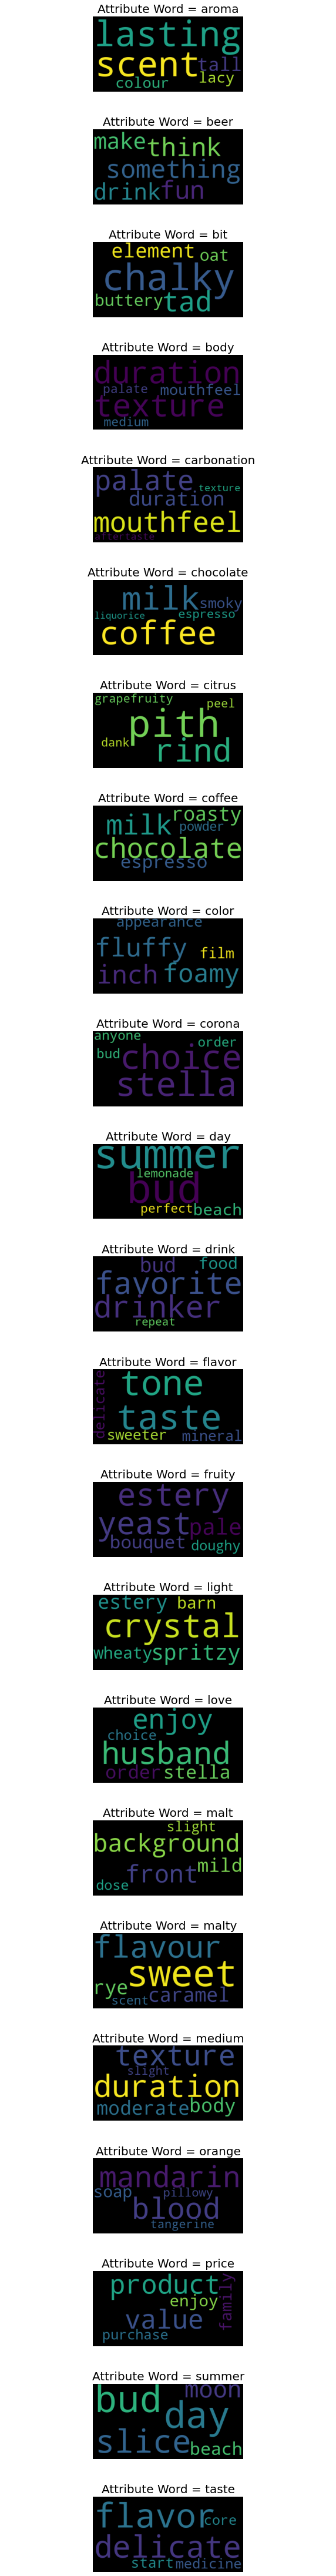

In [22]:
length = len(dic_wordcloud)
i = 1
fig = plt.figure(figsize=[10,80])
plt.tight_layout()
plt.axis('off')
for word,similarities in sorted(dic_wordcloud.items()):
    ax = fig.add_subplot(length,1,i)
    ax.imshow(WordCloud().generate(similarities))
    ax.set_title("Attribute Word = {}".format(word),size = 20)
    ax.axis('off')
    i = i+1
plt.subplots_adjust(hspace=0.5)


Saving figure Popular Brands


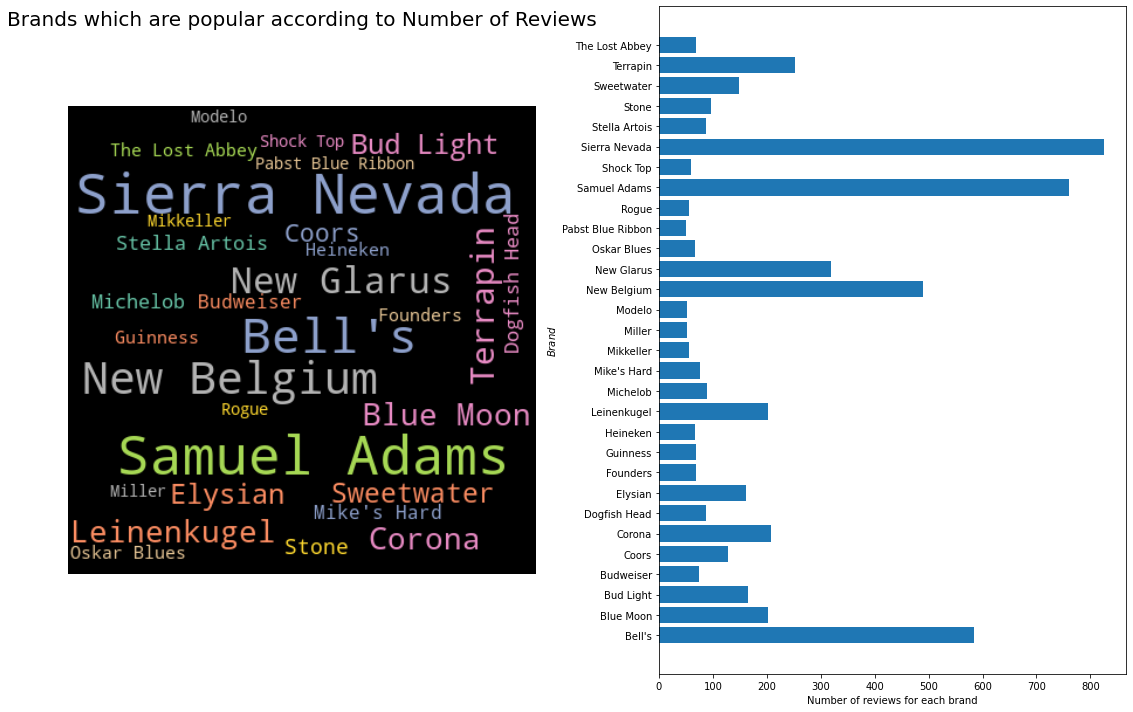

In [23]:
reviews_at_brand = train.groupby(['brand']).size().reset_index(name = 'Count_of_Reviews')
number_of_reviews= reviews_at_brand.loc[reviews_at_brand['Count_of_Reviews'] > 50]
d = {}
for brand,count in number_of_reviews.values:
    d[brand] = count
plt.figure(figsize = [15,10])
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(WordCloud(colormap='Set2',height = 400).generate_from_frequencies(frequencies = d),interpolation = 'bilinear')
plt.subplot(1,2,2)
plt.axis('on')
plt.barh(number_of_reviews['brand'],number_of_reviews['Count_of_Reviews'])
plt.suptitle("Brands which are popular according to Number of Reviews",ha = 'right',fontsize = 20)
plt.gca().set(ylabel = '$Brand$',xlabel = 'Number of reviews for each brand')
plt.tight_layout()
save_fig("Popular Brands")

Saving figure Sentiment score


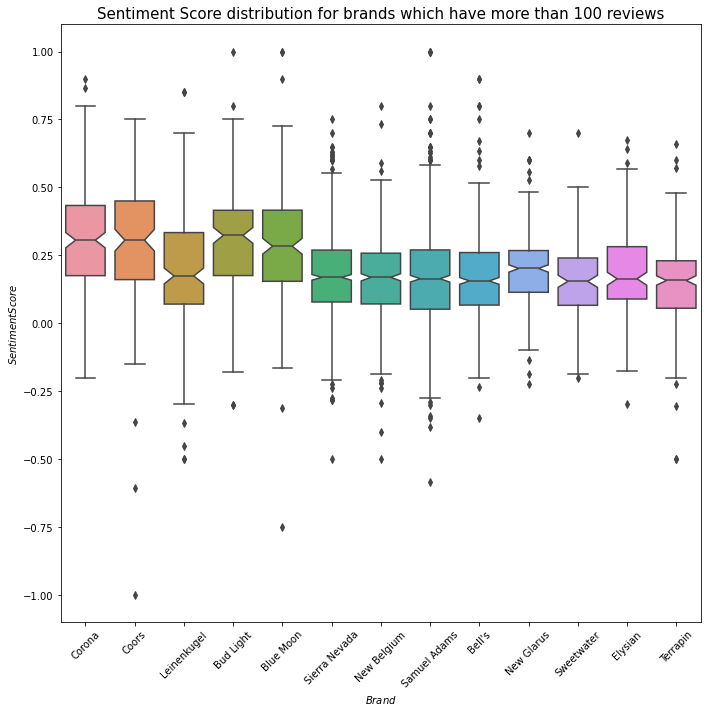

In [24]:
train_new = pd.merge(train,reviews_at_brand,on = 'brand')
brands_to_visualize = (train_new.loc[(train_new.Count_of_Reviews > 100)])
brand_sentiments = brands_to_visualize.groupby(['brand']).agg({'sentiment':np.mean}).reset_index()
brands = brand_sentiments.brand
plt.figure(figsize = [10,10])
sns.boxplot(x = 'brand',y = 'sentiment',notch = True, data = train.loc[train.brand.isin(brands)])
plt.title('Sentiment Score distribution for brands which have more than 100 reviews',fontsize = 15)
plt.xticks(rotation = 45)
plt.gca().set(xlabel = '$Brand$',ylabel = '$Sentiment Score$')
save_fig("Sentiment score")

In [25]:
data_new = train.loc[train.brand.isin(brands)]
dy_data = data_new.groupby(['brand','product']).agg({'sentiment':np.mean}).reset_index()

In [26]:
fig = go.Figure()
brand_list = data_new.brand.unique()

fig.layout = {}
for brand in brand_list:
  fig.add_trace(go.Bar(x = dy_data['product'][dy_data['brand']==brand],y = dy_data['sentiment'][dy_data['brand']==brand],orientation='v',name = brand))

buttons = []

for i, brand in enumerate(brand_list):
    args = [False] * len(brand_list)
    args[i] = True
    
    #create a button object for the country we are on
    button = dict(label = brand,
                  method = "update",
                  args=[{"visible": args}])
    
    #add the button to our list of buttons
    buttons.append(button)
    
fig.update_layout(
    updatemenus=[dict(
                    active=0,
                    type="dropdown",
                    buttons=buttons,
                    xanchor = 'left',
                    yanchor = 'bottom'
                )], 
    autosize=True,
    width=1500,
    height=800,
    xaxis1_rangeslider_visible = True,
    title=go.layout.Title(text="Sentiment Distribution across product brands with functionality to visualize average sentiment of product reviews under filtered brands")
)


fig
#save_fig("Sentiment Distribution")

### *End of  Case Study will work on Objective 4 in case of time left and save it locally*

In [27]:
new_train = train.loc[train.brand.isin(brands)][['brand','content']]
new_train['brand_review'] = new_train[['brand','content']].groupby(['brand'])['content'].transform(lambda x : ''.join(x))
new_train = new_train[['brand','brand_review']].drop_duplicates()

In [28]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

**Methodology #2 to extract Attributes from ratings:**



1.   Lemmatize and Stem the content of the reviews
2.   Using Count Vectorizer generate all the nouns features
3.   Generate Embeddings using pretrained sentence transformer model
4.   Generate Embedding for each of the reviews and extract attributes using cosine similarity between review embeddings and noun embeddings
5.    Extract top 5 similarity matches for each of the review

*This Method does not seems to be performing better than the **Topic Modelling** as the extracted attribtes from topic modelling seems more generalized than embeddings method*







In [29]:
stemmer = SnowballStemmer(language = 'english')
def lemmatize_stemming(text):
    before = text.split(' ')
    after = []
    for word in before:
      after.append(stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')))
    return ' '.join(word for word in after)
lemmatize_stem_content = train['content'].apply(lambda x : lemmatize_stemming(x))

In [30]:
all_collated_sentences = ' '.join(lemmatize_stemming(sentence) for sentence in all_sentences)
counts = CountVectorizer(ngram_range=(1,1), stop_words=stop_words).fit([all_collated_sentences])
noun_candidates  = counts.get_feature_names()
noun_candidate_embeddings = model.encode(noun_candidates)

In [31]:
att_using_embedding = []
for content in tqdm(lemmatize_stem_content):
  review_embedding = model.encode([content])
  top_n = 5
  distances = cosine_similarity(review_embedding, noun_candidate_embeddings)
  keywords = ','.join(noun_candidates[index] for index in distances.argsort()[0][-top_n:])
  att_using_embedding.append(keywords)
  #print("Review : {} \n Extracted Keywords : {} ".format(content,keywords))

100%|██████████| 9185/9185 [28:26<00:00,  5.38it/s]


In [32]:
final_data_with_att = train.copy()
final_data_with_att['final_att'] = att_using_embedding
final_data_with_att.to_csv('final_output.csv',index = False)

###**Objective 4:**

